# Stars Dataset

In this project, we use the dataset called 'Star dataset to predict star types', which is publicly available at the Kaggle platform.

## Goals

We set ourselves, for this dataset, the goal of training a model for predicting the star type of a given star.
Thus, we must accomplish two main objectives:

- carry out an EDA of the dataset in order to get insights about the data relations and selecting the appropriate features for model training;
- selecting, testing and comparing the perfomance of different models.

# 0 SETUP

## 0.1 Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Learning libraries
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# other ML libraries
from umap import UMAP

## 0.2 Helper Functions

### 0.2.1 Data Visualization Functions

In [3]:
def create_bin_range_variable(df, target_column):
    # this function creates dummy variables used for visualization purposes in histograms:
    # to create a proper hue parameter to be given to the histplot seaborn function
    # theses variables are appended on the dataframe, and get the label 'bin (vis)' in their names.
    # don't forget to drop them off after use.
    #
    # INPUT: dataframe and target column
    # OUTPUT: bins of the histogram computed by plt

    n, bins = np.histogram(df[target_column]) 

    df[target_column + ' bin (vis)'] = 1
    bin_count = 1
    
    for bin in zip(bins[0:], bins[1:]):    
        lb_index_array = np.where(df[target_column] > bin[0])
        up_index_array = np.where(df[target_column] <= bin[1])
        interval_index_array = np.intersect1d(lb_index_array, up_index_array)
        df.loc[interval_index_array, target_column + ' bin (vis)'] = bin_count    
        bin_count += 1

    return bins

### 0.2.2 Data Manipulation Functions

In [4]:
def check_nans(df_column):    
    
    lista = df_column.isnull().values.tolist()
    count = sum((x is not False for x in lista))
    
    return count

def assemble_data_description_table(df):

    c1 = pd.DataFrame([df.name]*len(df.columns))
    c2 = pd.DataFrame([df.shape[0]]*len(df.columns))
    c3 = pd.DataFrame(df.columns)
    c4 = pd.DataFrame(df.dtypes.values)    
    c5 = pd.DataFrame(df.apply(check_nans))
    c5 = pd.DataFrame(c5.iloc[:,-1:].values)
    
    data_description_table = pd.concat([c1, c2, c3, c4, c5], axis=1)
    data_description_table.columns = ['dataset_name', 'rows_number', 'var_name', 'dtype', 'nans_number']

    return data_description_table

def show_descriptive_statistics(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean))
    ct2 = pd.DataFrame(df.apply(np.median))    

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std))
    d2 = pd.DataFrame(df.apply(min))
    d3 = pd.DataFrame(df.apply(max))
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    d5 = pd.DataFrame(df.apply(lambda x: x.skew()))
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis()))

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std', 'skew', 'kurtosis']    
    return m

## 0.3 Path Definition

In [5]:
HOME_PATH = '~/Documents/Data Science Projects/stars'
RAW_DATA_PATH = '/data/raw/'
INTERIM_DATA_PATH = '/data/interim/'

## 0.4 Loading Data

In [6]:
stars_raw = pd.read_csv(HOME_PATH + RAW_DATA_PATH +  "stars.csv")
stars_raw

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


## 0.5 Setting DFs Names

In [7]:
stars_raw.name = 'stars_dataset'

# 1 DATA DESCRIPTION

The star type, our target variable, is coded in the following way:


- Brown Dwarf -> Star Type = 0
- Red Dwarf -> Star Type = 1
- White Dwarf-> Star Type = 2
- Main Sequence -> Star Type = 3
- Supergiant -> Star Type = 4
- Hypergiant -> Star Type = 5.

## 1.1 Data fields, dtypes, shapes and NANs.

First, let's put up a table showing some basic information about our dataset.

In [8]:
data_description_table = assemble_data_description_table(stars_raw)
data_description_table

,dataset_name,rows_number,var_name,dtype,nans_number
0,stars_dataset,240,Temperature (K),int64,0
1,stars_dataset,240,Luminosity(L/Lo),float64,0
2,stars_dataset,240,Radius(R/Ro),float64,0
3,stars_dataset,240,Absolute magnitude(Mv),float64,0
4,stars_dataset,240,Star type,int64,0
5,stars_dataset,240,Star color,object,0
6,stars_dataset,240,Spectral Class,object,0


# 2 Variable Transformation

In [9]:
stars_2 = stars_raw.copy()
stars_2.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'stars_2.csv')

# changing the columns order on the dataset
columns_list = list(stars_2.columns.values)
columns_list.pop(4)
columns_list.insert(0, 'Star type')
stars_2 = stars_2[columns_list]

## 2.0 Category Transformation

Because of string formatting issues, some star color names are being taken as multiple different categories like: 'Blue' and 'Blue '. We will adress this issue here, by unifying the duplicate categories.

In [10]:
category_mapping = {
    'Blue ': 'Blue',
    'Blue White': 'Blue_White',
    'Blue white': 'Blue_White',
    'Blue white ': 'Blue_White',
    'Blue-White': 'Blue_White',
    'Blue-white': 'Blue_White',
    'Orange-Red': 'Orange_Red',
    'Pale yellow orange': 'Pale_Yellow_Orange',
    'White-Yellow': 'White_Yellow',
    'Whitish': 'Whitish',
    'Yellowish': 'Yellowish',
    'Yellowish White': 'Yellowish_White',
    'white': 'White',
    'yellow-white': 'Yellow_White',
    'yellowish': 'Yellowish'
}

stars_2['Star color'] = stars_2['Star color'].replace(category_mapping)

## 2.1 Ordinal Transformation

By looking at the previous table, we can see two variables in string format. As these variables are both categorical, we will transform them into ordinal categorical variables and attach them to the dataframe.

In [11]:
ord_enc = OrdinalEncoder()
stars_2['Star color encoded'] = ord_enc.fit_transform(stars_2[['Star color']])
stars_2['Spectral class encoded'] = ord_enc.fit_transform(stars_2[['Spectral Class']])
stars_2

,Star type,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class,Star color encoded,Spectral class encoded
0,0,3068,0.002400,0.1700,16.12,Red,M,5.0,5.0
1,0,3042,0.000500,0.1542,16.60,Red,M,5.0,5.0
2,0,2600,0.000300,0.1020,18.70,Red,M,5.0,5.0
3,0,2800,0.000200,0.1600,16.65,Red,M,5.0,5.0
4,0,1939,0.000138,0.1030,20.06,Red,M,5.0,5.0
...,...,...,...,...,...,...,...,...,...
235,5,38940,374830.000000,1356.0000,-9.93,Blue,O,0.0,6.0
236,5,30839,834042.000000,1194.0000,-10.63,Blue,O,0.0,6.0
237,5,8829,537493.000000,1423.0000,-10.73,White,A,6.0,0.0
238,5,9235,404940.000000,1112.0000,-11.23,White,A,6.0,0.0


# 3 Exploratory Data Analysis

In [12]:
stars_3 = stars_2.copy()
stars_3.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'stars_3.csv')


## 3.1 Quantitative Measures

We compute and present some common statistical moments for our numerical variables.

In [13]:
num_attributes = stars_raw.select_dtypes(include=['int64', 'float64'])
num_attributes.drop('Star type', axis=1, inplace=True)
moments_table = show_descriptive_statistics(num_attributes)
moments_table 

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Temperature (K),1939.00000,40000.00,38061.00000,10497.462500,5776.0000,9532.503378,1.321568,0.877352
1,Luminosity(L/Lo),0.00008,849420.00,849419.99992,107188.361635,0.0705,179058.037557,2.068069,4.465098
2,Radius(R/Ro),0.00840,1948.50,1948.49160,237.157781,0.7625,516.077231,1.946800,2.072935
3,Absolute magnitude(Mv),-11.92000,20.06,31.98000,4.382396,8.3130,10.510547,-0.121540,-1.655888


## 3.2 Univariate Analysis

We generate data visualizations over single variables to take a closer look at their distributions.

### 3.2.1 Numerical Variables

We plot histograms of the numerical attributes of our dataset. Those being:

- Temperature (K)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv).

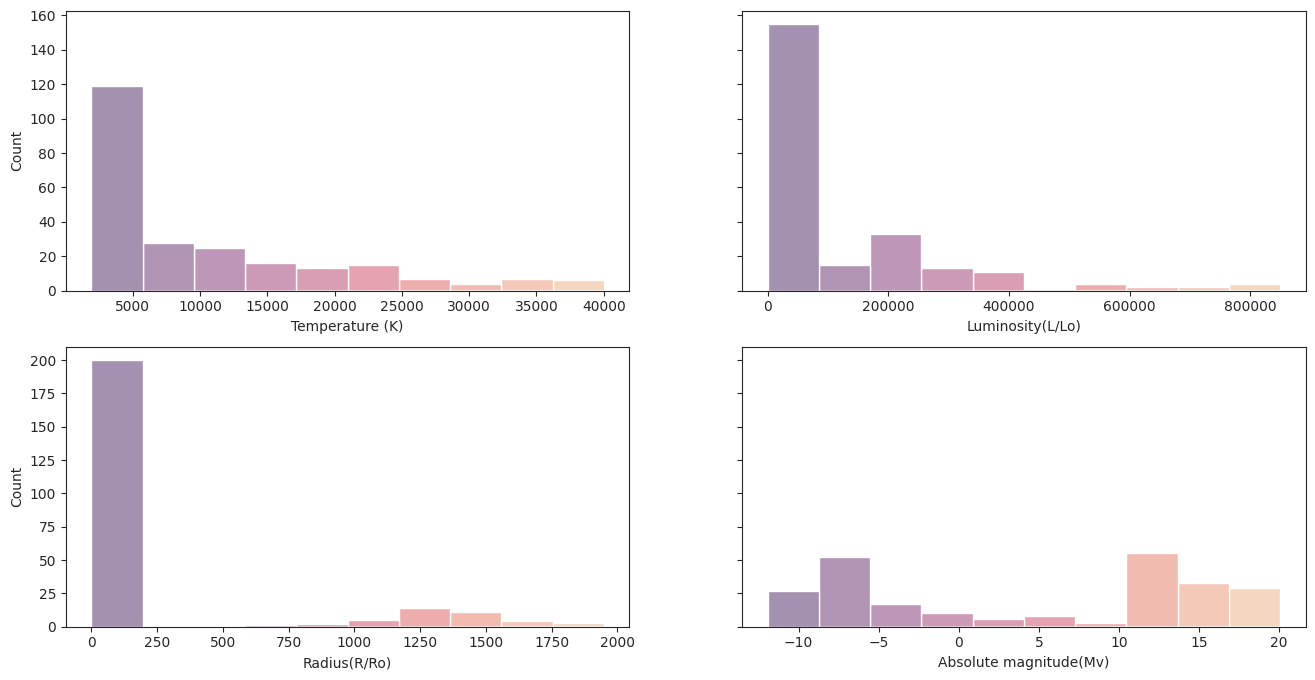

In [14]:
sns.set_style('ticks')

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey = 'row',figsize = (16, 8))
first_four_axs = [ax0, ax1, ax2, ax3]

for feature, ax in zip(num_attributes.columns, first_four_axs):
    var_bins = create_bin_range_variable(stars_3, feature)    

    sns.histplot(data = stars_3,
                 bins = var_bins,
                 x = feature,
                 hue = feature + ' bin (vis)',
                 palette = 'flare_r',
                 legend = False, 
                 ax = ax
                )
plt.show()

### 3.2.1 Categorical Variables

We plot the counts of the categorical attributes of our dataset. Those being:

- Star Color (White, Red, Blue, Yellow etc)
- Spectral Class (O, B, A, F, G, K, M)
- Star Type (Brown Dwarf, Red Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants).

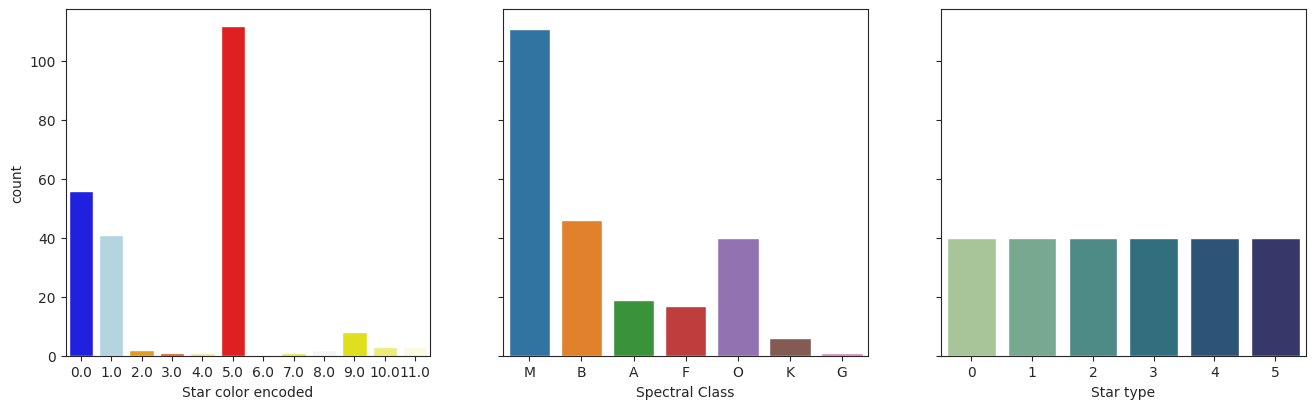

In [15]:
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, sharey = 'row', figsize = (16, 4.5))

color_codes_list = [
    '#0000FF',  # Blue
    '#ADD8E6',  # Blue_White
    '#FFA500',  # Orange
    '#FF4500',  # Orange_Red
    '#FFEC8B',  # Pale_Yellow_Orange
    '#FF0000',  # Red
    '#FFFFFF',  # White
    '#FEFE33',  # White_Yellow
    '#F5F5F5',  # Whitish
    '#FFFF00',  # Yellow_White
    '#FFFF66',  # Yellowish
    '#FFFFE0'   # Yellowish_White
]

star_color_palette = sns.color_palette(color_codes_list)

sns.countplot(data = stars_3,                 
                 x = 'Star color encoded',                                  
                 hue = 'Star color encoded',
                 palette = star_color_palette,                 
                 legend = False, 
                 ax = ax4
                )

sns.countplot(data = stars_3,                 
                 x = 'Spectral Class',                                  
                 hue = 'Spectral Class',                 
                 legend = False, 
                 ax = ax5
                )

sns.countplot(data = stars_3,                 
                 x = 'Star type',
                 hue = 'Star type',
                 palette = 'crest',
                 legend = False,
                 ax = ax6              
                )

plt.show()

## 3.3 Bivariate Analysis

We will plot two dimensional visualizations between our target variable (Star type) and the other features.

### 3.2.1 Target vs Numerical Variables

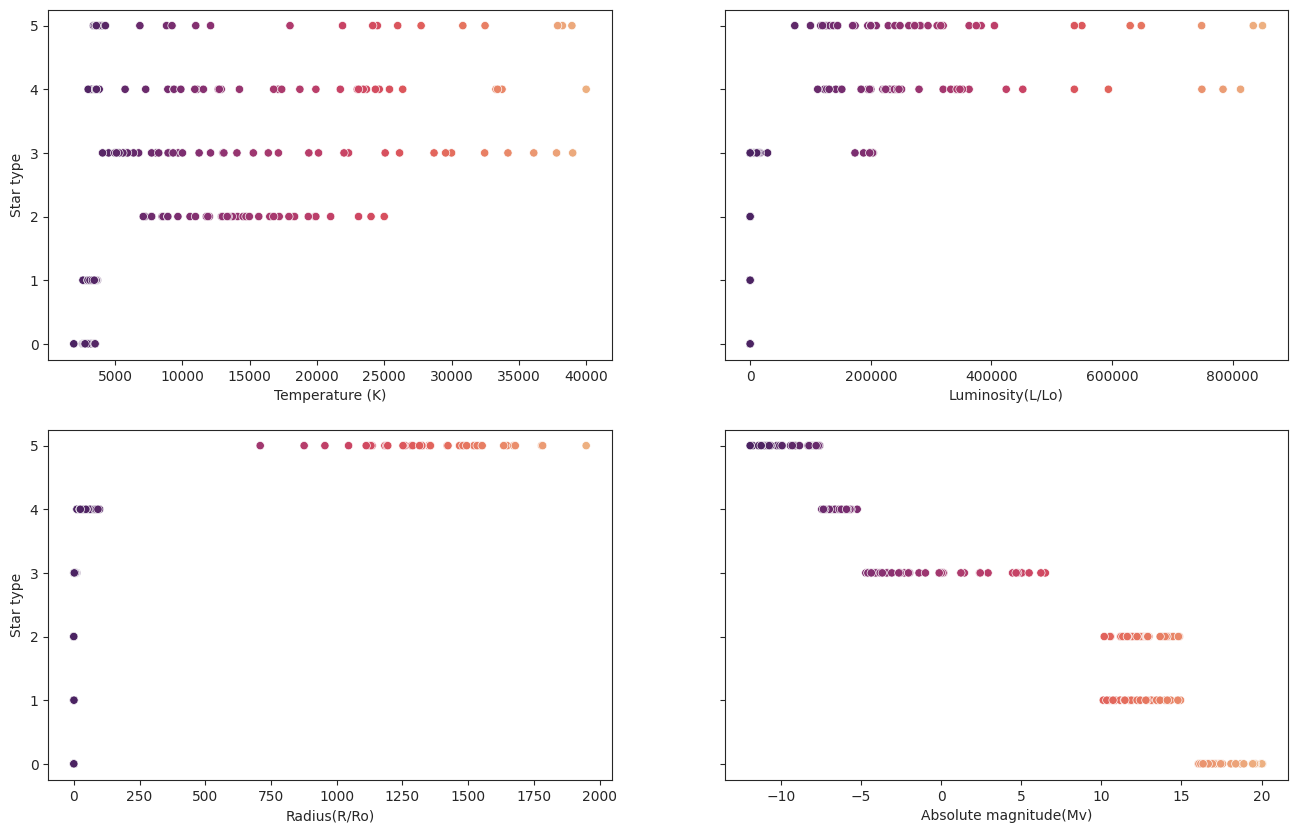

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey = 'row',figsize = (16, 10))
first_four_axs = [ax0, ax1, ax2, ax3]

for feature, ax in zip(num_attributes.columns, first_four_axs):       

    sns.scatterplot(data = stars_3,
                    x = feature,
                    y = 'Star type',
                    hue = feature,
                    palette = 'flare_r',
                    legend = False, 
                    ax = ax
                    )
plt.show()

### 3.2.2 Target vs Categorical Variables

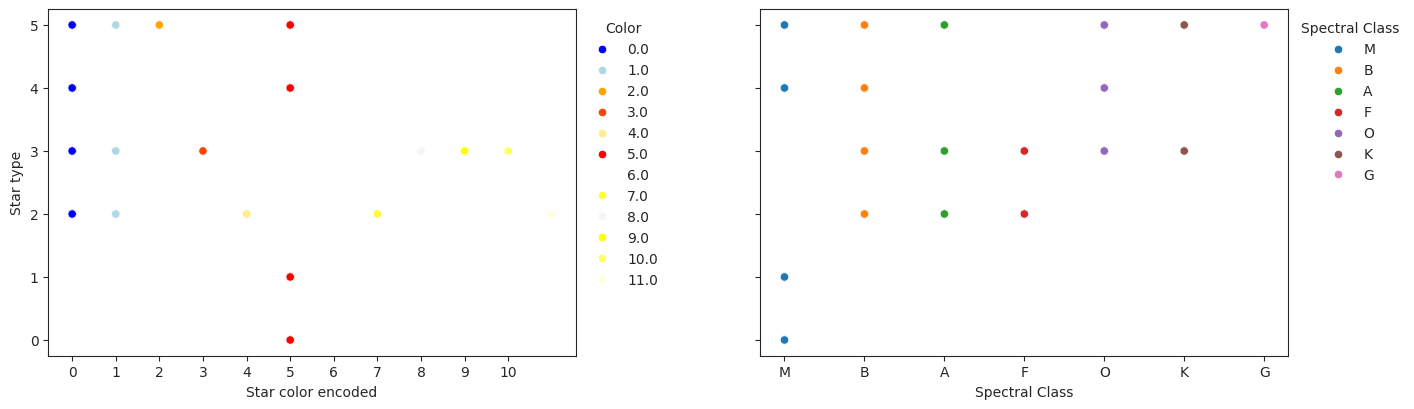

In [17]:
fig, (ax4, ax5) = plt.subplots(1, 2, sharey = 'row', figsize = (16, 4.5))
fig.subplots_adjust(wspace = 0.35)     

sns.scatterplot(data = stars_3,
                x = 'Star color encoded',
                y = 'Star type',
                hue = 'Star color encoded',
                palette = star_color_palette,                
                legend = True, 
                ax = ax4                
                )

sns.scatterplot(data = stars_3,
                x = 'Spectral Class',
                y = 'Star type',
                hue = 'Spectral Class',                               
                legend = True, 
                ax = ax5                
                )

ax4.set(xticks = np.arange(11))
ax4.legend(fontsize = 'small', title = 'Color')
sns.move_legend(ax4, 'best', ncol=1, bbox_to_anchor=(1, 1), frameon=False)
sns.move_legend(ax5, 'best', ncol=1, bbox_to_anchor=(1, 1), frameon=False)


plt.show()

## 3.3 Multivariate Analysis

Here, we plot some useful multivariable visualizations to look deeper at possible variable correlations.

### 3.3.1 Correlation Matrix

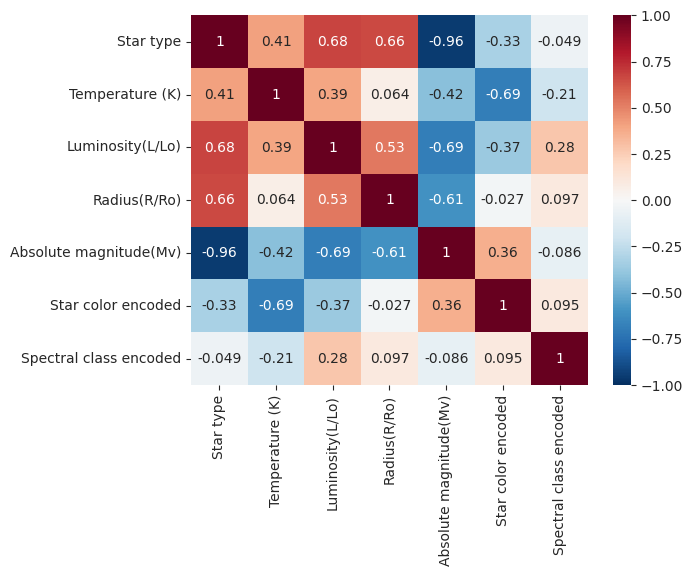

In [18]:
selected_features_df = stars_3[['Star type', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)',
                       'Star color encoded', 'Spectral class encoded']]

corr_matrix = selected_features_df.corr()

sns.heatmap(corr_matrix,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu_r',
            annot = True)
plt.show()

### 3.3.2 Manifold Visualization

We will use two manifold learning algorithms for dimensionality reduction: UMAP and t-SNE.

In [19]:
X = selected_features_df.drop('Star type', axis=1)
y = selected_features_df['Star type']

# scalling the sample vectos
X_scaled = StandardScaler().fit_transform(X)

In [20]:
# umap object
reducer = UMAP(n_neighbors = 6,
               n_epochs = 100               
               )

# tsne object
tsne = TSNE(perplexity = 30)  

X_embedded_umap = reducer.fit_transform(X_scaled)
X_embedded_tsne = tsne.fit_transform(X_scaled)

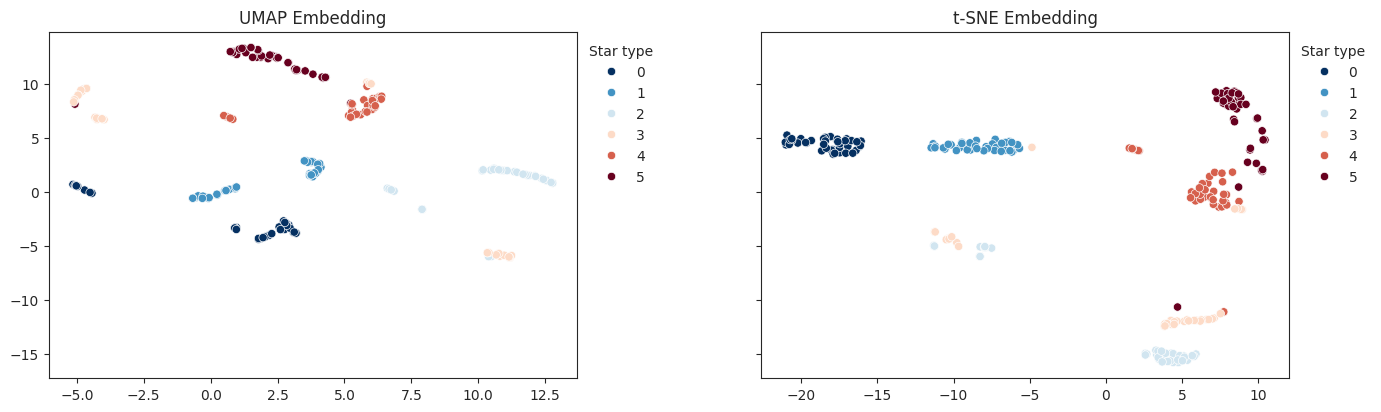

In [21]:
fig, (ax4, ax5) = plt.subplots(1, 2, sharey = 'row', figsize = (16, 4.5))
fig.subplots_adjust(wspace = 0.35)

ax = sns.scatterplot(x = X_embedded_umap[:, 0],
                     y = X_embedded_umap[:, 1],
                     hue = y, 
                     palette = 'RdBu_r',
                     ax = ax4
                    ).set(title='UMAP Embedding')

ax = sns.scatterplot(x = X_embedded_tsne[:, 0],
                     y = X_embedded_tsne[:, 1],
                     hue = y, 
                     palette = 'RdBu_r',
                     ax = ax5
                    ).set(title='t-SNE Embedding')



sns.move_legend(ax4, 'upper left', ncol=1, bbox_to_anchor=(1, 1), frameon=False)
sns.move_legend(ax5, 'upper left', ncol=1, bbox_to_anchor=(1, 1), frameon=False)

## 3.4 Some Conclusions

The separability of the features, as shown by our bivariate analysis, makes a strong case for using tree-type models. Besides, the manifold visualizations show a very clear clustering in our dataset. It seems that we have a promising setting to develop our models.

# 4 Machine Learning Models

As discussed in 3.4, we selected three tree-type models to apply to our data, those being:

- Classification and Regression Trees (CART);
- Random Forest;
- Gradient Boosted Trees.

## 4.1 Feature Selection

Based on the correlation matrix in 3.3.1, we will select the features that have corr>0.3 with our target variable.

In [22]:
selected_features_df_final = selected_features_df.drop('Spectral class encoded', axis=1).copy()
selected_features_df_final.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'selected_features_df_final.csv')

In [23]:
X = selected_features_df_final.drop('Star type', axis = 1)
y = selected_features_df_final['Star type']

## 4.2 Model Fitting

In [24]:
# setting the training split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

### 4.2.1 CART

In [25]:
# setting up the model. we use 4 maximum depth, with no minimum leaf size
cart_model = tree.DecisionTreeClassifier(max_depth = 4)

# fitting the model to the training data
cart_classifier = cart_model.fit(X_train, y_train)

# getting model predictions over the test set
cart_pred_labels_te = cart_model.predict(X_test)

# model perfomance report
print('=================== CART ===================')
print('Classes: ', cart_classifier.classes_)
print('Tree Depth: ', cart_classifier.tree_.max_depth)
print('No. of leaves: ', cart_classifier.tree_.n_leaves)
print('No. of features: ', cart_classifier.n_features_in_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
print(classification_report(y_test, cart_pred_labels_te, zero_division=0))

=================== CART ===================
Classes:  [0 1 2 3 4 5]
Tree Depth:  4
No. of leaves:  5
No. of features:  5
--------------------------------------------------------

*************** Evaluation on Test Data ***************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.49      1.00      0.66        21
           2       1.00      1.00      1.00        16
           3       0.00      0.00      0.00        22
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        21

    accuracy                           0.82       120
   macro avg       0.75      0.83      0.78       120
weighted avg       0.73      0.82      0.76       120



### 4.2.2 Random Forest

In [26]:
# setting up the model. we use 4 maximum depth, and 1000 decision tress
rf_model = RandomForestClassifier(max_depth=4,                                  
                                  n_estimators=1000
                                 )

# fitting the model to the training data
rf_classifier = rf_model.fit(X_train, y_train)

# getting model predictions over the test set
rf_pred_labels_te = rf_model.predict(X_test)

# model perfomance report
print('=================== RANDOM FOREST ===================')
print('Classes: ', rf_classifier.classes_)
print('No. of outputs: ', rf_classifier.n_outputs_)
print('No. of features: ', rf_classifier.n_features_in_)
print('No. of Estimators: ', len(rf_classifier.estimators_))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
print(classification_report(y_test, rf_pred_labels_te, zero_division=0))

=================== RANDOM FOREST ===================
Classes:  [0 1 2 3 4 5]
No. of outputs:  1
No. of features:  5
No. of Estimators:  1000
--------------------------------------------------------

*************** Evaluation on Test Data ***************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        21

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



### 4.2.3 Gradient Boosted Trees

In [27]:
# setting up the model. we use 4 maximum depth, and 1000 decision tress
gb_model = GradientBoostingClassifier(max_depth = 4,
                                      max_features = 'sqrt',
                                      n_estimators = 1000
                                     )

# fitting the model to the training data
gb_classifier = gb_model.fit(X_train, y_train)

# getting model predictions over the test set
gb_pred_labels_te = gb_model.predict(X_test)

# model perfomance report
print('=================== GRADIENT BOOSTED TREES ===================')
print('Classes: ', gb_classifier.classes_)
print('No. of features: ', gb_classifier.n_features_in_)
print('No. of Estimators: ', len(gb_classifier.estimators_))
print('Loss at last iteration: ', gb_classifier.train_score_[-1])
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
print(classification_report(y_test, gb_pred_labels_te, zero_division=0))

=================== GRADIENT BOOSTED TREES ===================
Classes:  [0 1 2 3 4 5]
No. of features:  5
No. of Estimators:  1000
Loss at last iteration:  2.4862451815839866e-08
--------------------------------------------------------

*************** Evaluation on Test Data ***************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        21

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



## 4.3 Models Comparison and Some Conclusions

It's clear from the perfomance reports that we have appropriate models for our prediction problem (perfect scores for the last two), which seems to justify our choice of tree type ones. Maybe some other type of models could get that kind of score too?

Also, even for a single decision tree, the score is ok-ish enough. Maybe it could be improved by taking a closer look at what is making it underperform when predicting classes 3 and 4, since it's where all of the misclassifications are being made.